<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/all_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Tue Oct  4 20:39:47 UTC 2022


In [2]:
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
  !pip install -U matplotlib
  !pip install --quiet kb-python 
  !pip install --no-deps -i https://test.pypi.org/simple/ diffmx==0.0.5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 5.9 MB/s 
     |████████████████████████████████| 960 kB 42.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


     |████████████████████████████████| 7.5 MB 7.0 MB/s 
     |████████████████████████████████| 96 kB 6.2 MB/s 
     |████████████████████████████████| 4.8 MB 44.5 MB/s 
     |████████████████████████████████| 45.2 MB 1.3 MB/s 
     |████████████████████████████████| 2.0 MB 41.3 MB/s 
     |████████████████████████████████| 15.1 MB 99 kB/s 
     |████████████████████████████████| 88 kB 7.4 MB/s 
     |████████████████████████████████| 1.1 MB 49.4 MB/s 
     |████████████████████████████████| 63 kB 2.6 MB/s 
Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!rm -rf BMGP_2020
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 1120, done.
remote: Counting objects: 100% (303/303), done.
remote: Compressing objects: 100% (187/187), done.
remote: Total 1120 (delta 130), reused 256 (delta 114), pack-reused 817
Receiving objects: 100% (1120/1120), 496.07 MiB | 27.31 MiB/s, done.
Resolving deltas: 100% (454/454), done.
Checking out files: 100% (154/154), done.


In [2]:
!gunzip BMGP_2020/data/*/*.h5ad.gz

In [3]:
import anndata
from glob import glob
from scipy.io import mmread, mmwrite
from kb_python.utils import import_matrix_as_anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from diffmx import plot, compare
from diffmx.utils import nd, yex

fsize = 18

plt.rcParams.update({'font.size': fsize})

%config InlineBackend.figure_format = 'retina'

In [4]:
files = glob("BMGP_2020/data/*/*.h5ad")

In [5]:
names = []
data = []
for f in files:
  name = name = f.split("/")[-1].split(".")[0]
  d = anndata.read_h5ad(f)
  if name != 'tapseq':
    names.append(name)
    data.append(d)
  else:
    tapseq = d

In [6]:
data

[AnnData object with n_obs × n_vars = 10807 × 8
     var: 'feature_name'
     layers: '0', '1', AnnData object with n_obs × n_vars = 2799 × 90
     var: 'feature_name'
     layers: '0', '1', AnnData object with n_obs × n_vars = 3795 × 8
     var: 'feature_name'
     layers: '0', '1', AnnData object with n_obs × n_vars = 5266 × 32
     var: 'feature_name'
     layers: '0', '1', AnnData object with n_obs × n_vars = 11568 × 9
     var: 'feature_name'
     layers: '0', '1']

In [7]:
delta = [(i.layers['0'].mean() - i.layers['1'].mean()) for i in data]
n_cells = [i.shape[0] for i in data]

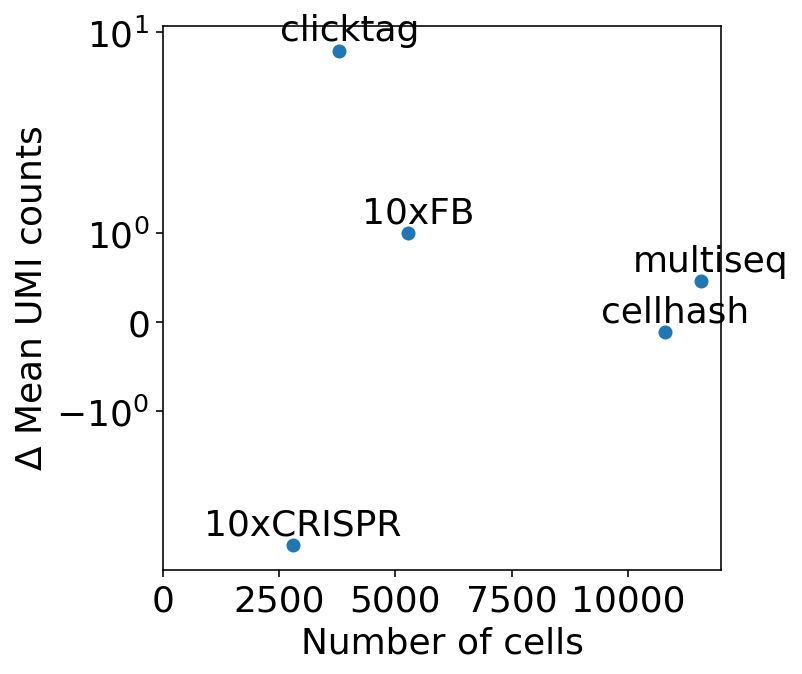

In [8]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(n_cells, delta)

for (x,y,t) in zip(n_cells, delta, names):
  
  ax.annotate(t, (x,y), ha="center", xycoords='data',
            xytext=(5, 5), textcoords='offset points',)

ax.set(**{
    "yscale": "symlog", 
    "xlabel": "Number of cells",
    "ylabel": "$\Delta$ Mean UMI counts",
    "xlim": 0
    })

fig.show()

In [9]:
corr = [compare.features_correlated(i.layers['0'], i.layers['1'])[1] for i in data]
n_feat = [i.shape[1] for i in data]

In [10]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax

In [11]:
names_s = np.array([
  "clicktag",
  "10xFB",
  "cellhash",
  "multiseq",
  "10xCRISPR"
])

In [12]:
[i for i in names_s]

['clicktag', '10xFB', 'cellhash', 'multiseq', '10xCRISPR']

In [13]:
names.index("clicktag")

2

In [14]:
corr_idx = [names.index(i) for i in names_s]

In [15]:
corr_s = [corr[i] for i in corr_idx]

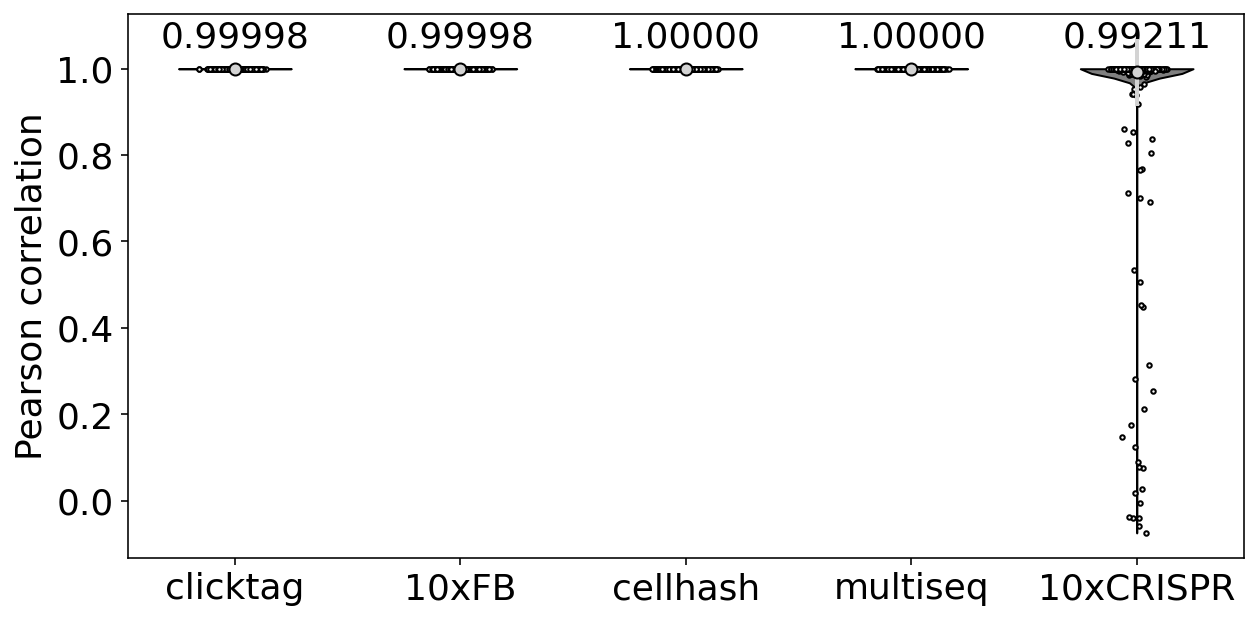

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

violinplot(corr_s, ax, xticklabels=names_s)
ax.set(**{
    "ylabel": "Pearson correlation",
})

for i in range(1, len(corr_s)+1):
  ax.annotate(f"{corr_s[i-1].mean():,.5f}", (i, 1.05), ha="center")

fig.savefig("all_pearson.png", dpi=300, bbox_inches="tight")
fig.show()

In [17]:
[(name, i.mean()) for name, i in zip(names_s, corr_s)]

[('clicktag', 0.9999834257913326),
 ('10xFB', 0.9999808521438808),
 ('cellhash', 0.999998764078696),
 ('multiseq', 0.9999988752780213),
 ('10xCRISPR', 0.9921092975476486)]

In [18]:
[(name, i.mean()) for name, i in zip(names, corr)]

[('cellhash', 0.999998764078696),
 ('10xCRISPR', 0.9921092975476486),
 ('clicktag', 0.9999834257913326),
 ('10xFB', 0.9999808521438808),
 ('multiseq', 0.9999988752780213)]